<a href="https://colab.research.google.com/github/KoYesung/Kaggle/blob/master/Alien%EA%B3%BC_Predator_%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 에일리언 vs 프레데터 데이터셋
* https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images
* 캐글 로그인 -> 본인 계정 클릭 -> Your Porfile -> Account -> API 항목의 Create New Token -> json 다운로드
```
 {"username":"yesunggg","key":"be2f1881abb061c43bc8fd63019d6580"}
 ```

In [ ]:
import os

In [ ]:
# 캐글에서 데이터셋을 받을때 토큰값을 보내 접근 가능하게 함
os.environ['KAGGLE_USERNAME'] = 'yesunggg'  # username
os.environ['KAGGLE_KEY'] = 'be2f1881abb061c43bc8fd63019d6580'  # token key

In [ ]:
!kaggle datasets download -d pmigdal/alien-vs-predator-images
!unzip -q alien-vs-predator-images.zip

alien-vs-predator-images.zip: Skipping, found more recently modified local copy (use --force to force download)
replace alien_vs_predator_thumbnails/data/train/alien/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 2. 이미지 증강 기법(Image Augmentation)
* [도큐먼트](https://pytorch.org/vision/master/transforms.html)
* 원본 이미지(데이터)를 조작하여 원본과는 크고 작은 변화를 가진 이미지를 생성
* 이미지에 다양한 변환을 적용하여 데이터셋을 다양화하고 확장하는 방법
  * 일반적으로 모델 성능이 좋아짐
  * 오버피팅(Over fitting) 방지


In [ ]:
# 🌟 Compose(): 여러개의 함수를 한꺼번에 적용하는 함수(여러 이미지 변환 함수들을 연속적으로 적용)
data_transforms = {
    'train':transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.RandomAffine(0, shear=10, scale=(0.8 , 1.2)),  # 랜덤하게 변경할 것을 선택(인덱스 0번부터 10가지 선택, 크기는 범위 +-20%하여 랜덤하게 변경)
        transforms.RandomHorizontalFlip(),  # 랜덤하게 이미지 좌우 반전
        transforms.ToTensor()  # 이미지를 텐서형으로 변환
    ]),
    # 테스트 할 이미지
    'validation': transforms.Compose([
      transforms.Resize([224, 224]),  # 사이즈 맞춤
      transforms.ToTensor()           # 텐서 변환
    ])
}

In [ ]:
 # 타겟 데이터를 받아 텐서형으로 바꿔주는 함수
def target_transforms(target):
  return torch.FloatTensor([target])

In [ ]:
# ImageFolder(): 특정 이미지 폴더를 데이터셋화 시킴, (데이터 경로, 데이터셋에 대해 적용할 이미지 변환(transform) 함수,  'train' 데이터셋의 타겟(레이블)에 대해 적용할 변환 함수)
# 데이터 셋 만들기
image_datasets = {
    'train': datasets.ImageFolder('data/train', data_transforms['train'], target_transform=target_transforms), # data 폴더 안에 train 폴더를 데이터셋화
    'validation': datasets.ImageFolder('data/validation', data_transforms['validation'], target_transform=target_transforms)
}

In [ ]:
# 데이터로더 만들기
dataloaders ={
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
  ),
    'validation':DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

print(len(image_datasets['train']), len(image_datasets['validation']))

694 200


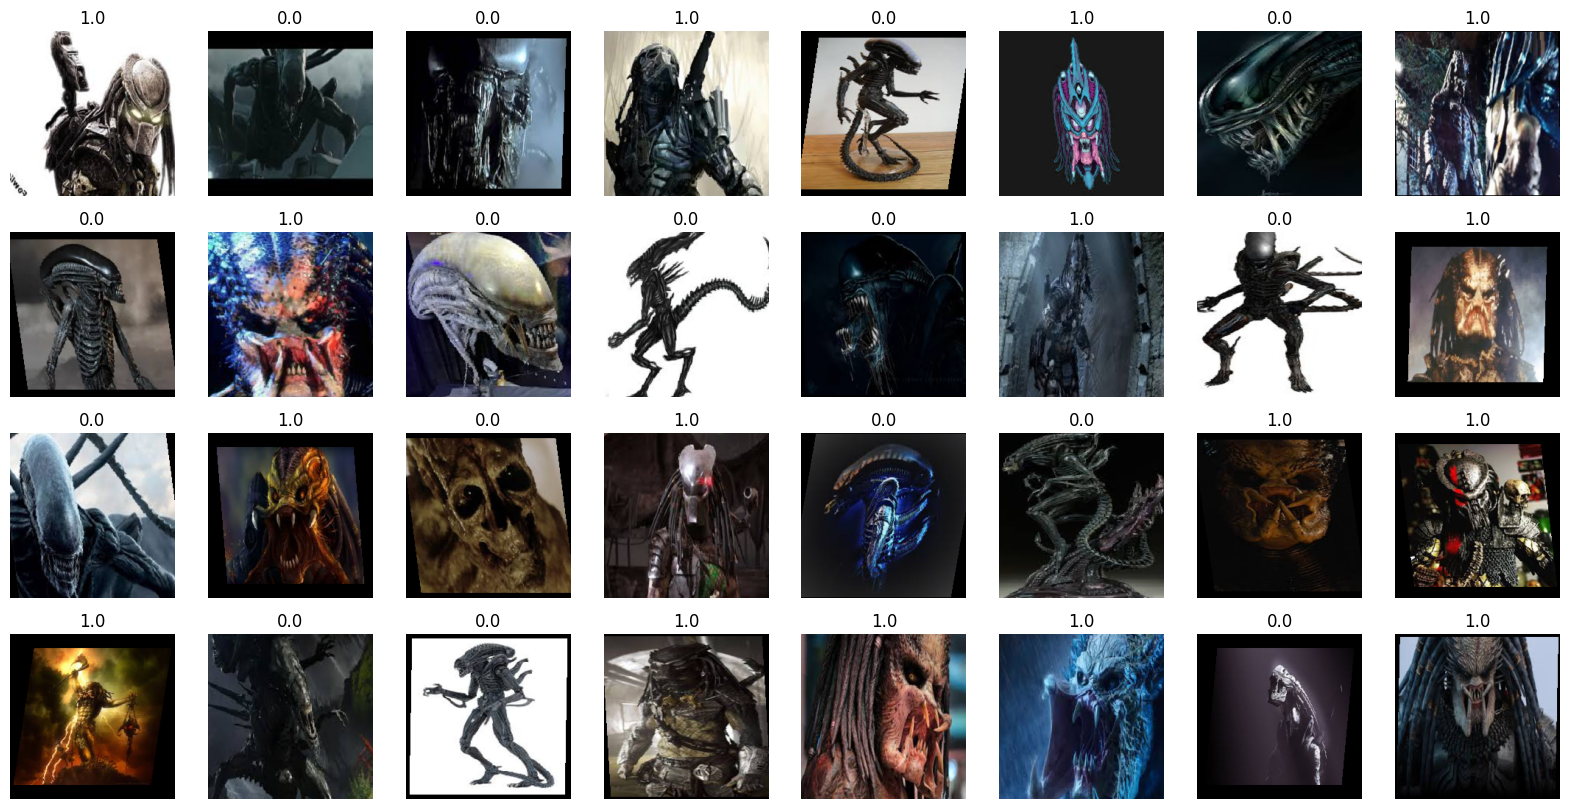

In [ ]:
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for img, label, ax in zip(imgs, labels, axes.flatten()):
  ax.set_title(label.item())
  ax.imshow(img.permute(1,2,0))  # 텐서에 저장되어있을 때 shape(컬러, 가로, 세로) -> matplotlib에서는 (가로, 세로, 컬러채널)
  ax.axis('off')

# 3. 전이 학습(Transfer Learning)
* 하나의 작업을 위해 훈련된 모델을 유사 작업 수행 모델의 시작점으로 활용하는 딥러닝 접근법
* 신경망은 처음부터 새로 학습하는것 보다 전이 학습을 통해 업데이트하고 재학습하는 편이 더 빠르고 간편함
* 전이 학습은 여러 응용 분야 중에서도 특히 검출, 영상 인식, 음성 인식, 글자 검색 분야에 많이 사용

![](https://miro.medium.com/max/1400/1*9GTEzcO8KxxrfutmtsPs3Q.png)


### 3-1. 전이 학습 시 고려할 점
* 크기: 모델 크기의 중요성은 모델을 배포할 위치와 방법에 따라 달라짐
* 정확도: 재훈련전의 모델 성능은 어느정도인지 확인이 필요
* 예측 속도: 하드웨어 및 배치 크기와 같은 다른 딥러닝 요소는 물론 선택된 모델의 아키텍처와 모델 크기에 따라서도 달라짐

![](https://kr.mathworks.com/discovery/transfer-learning/_jcr_content/mainParsys/image.adapt.full.medium.jpg/1634621302937.jpg)

# 4. 사전 학습 된 ResNet50 모델
* [파이토치에서 제공하는 사전학습 모델들](https://pytorch.org/vision/stable/models.html)

![](https://i.stack.imgur.com/gI4zT.png)


### 4-1. 이미지넷(ImageNet)
* 이미지 데이터베이스
* 1000개의 동물과 사물 이미지를 포함

![](https://i.imgur.com/5Rz5s8e.png)


In [ ]:
# 파이토치에서 제공하는 model 가져오기
# models.resnet50(pretrained=True).to(device) 와 비슷 -> 미리 학습된 모델을 쓰겠다.
model = models.resnet50(weights='IMAGENET1K_V1').to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 4-2. Freeze Layers
* 특징을 뽑아내는 CNN의 앞쪽 컨볼루션 레이어들은 학습을 하지 않도록 설정(학습을 시키지 않음)
* 출력 부분의 레이어(fc 레이어)를 다시 설정하여 분류에 맞게 설정
(원래 Resnet50 모델은 분류를 1000개의 클래스로 하는데 우리는 에일리언/프레데터 두가지로 분류하여야 하기 때문에)

In [ ]:
for param in model.parameters():
  param.requires_grad = False  # 가져온 파라미터(W, b)를 업데이트 하지 않음

# 모델의 FC 레이어
model.fc = nn.Sequential(
    nn.Linear(2048, 128),  # 입력 크기가 2048이고 출력 크기가 128인 선형 레이어
    nn.ReLU(),
    nn.Linear(128,1),  # 128차원의 특성을 1차원으로 줄이고, 최종 예측 값을 출력
    nn.Sigmoid()       # 출력을 0과 1 사이로 제한하여 이진 분류 문제에서 확률 값
).to(device)

In [ ]:
# 학습: FC 부분만 학습하므로 속도가 빠름
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs+1):
  for phase in ['train', 'validation']:  # train과  validation 따로 반복문을 돌아
    if phase == 'train':
      model.train()
    else:
      model.eval()   # 학습 모드에 있던 메모리를 지우고 바로 Test모드(훨씬 빠름)

    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in dataloaders[phase]:  # train이라면 train에 대한 데이터로더, validataion이라면 validation에 대한 데이터로더 (따로 쓰지 않고 합쳐서 씀)
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      y_pred = model(x_batch)

      loss = nn.BCELoss()(y_pred, y_batch)

      if phase == 'train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      sum_losses = sum_losses + loss

      y_bool = (y_pred >= 0.5).float()
      acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
      sum_accs = sum_accs + acc

    avg_loss = sum_losses / len(dataloaders[phase])
    avg_acc = sum_accs / len(dataloaders[phase])

    print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')


train     : Epoch    1/10, Loss: 0.4745, Accuracy: 79.91%
validation: Epoch    1/10, Loss: 0.5518, Accuracy: 68.30%
train     : Epoch    2/10, Loss: 0.2569, Accuracy: 90.35%
validation: Epoch    2/10, Loss: 0.2951, Accuracy: 86.61%
train     : Epoch    3/10, Loss: 0.2229, Accuracy: 91.14%
validation: Epoch    3/10, Loss: 0.2366, Accuracy: 89.29%
train     : Epoch    4/10, Loss: 0.1605, Accuracy: 94.19%
validation: Epoch    4/10, Loss: 0.2088, Accuracy: 91.07%
train     : Epoch    5/10, Loss: 0.2355, Accuracy: 89.93%
validation: Epoch    5/10, Loss: 0.2028, Accuracy: 90.63%
train     : Epoch    6/10, Loss: 0.1587, Accuracy: 94.60%
validation: Epoch    6/10, Loss: 0.1795, Accuracy: 93.30%
train     : Epoch    7/10, Loss: 0.1430, Accuracy: 94.25%
validation: Epoch    7/10, Loss: 0.1898, Accuracy: 91.07%
train     : Epoch    8/10, Loss: 0.1686, Accuracy: 93.07%
validation: Epoch    8/10, Loss: 0.1976, Accuracy: 90.18%
train     : Epoch    9/10, Loss: 0.1287, Accuracy: 94.89%
validation: Ep

In [ ]:
torch.save(model.state_dict(), 'model.h5')  #  모델의 현재 상태를 담고 있는 딕셔너리를 반환하고 'model.h5'라는 이름으로 저장

In [ ]:
# 이미지넷 가져오지않음 (껍데기만 가져옴)
model = models.resnet50().to(device)

# 모델의 FC 레이어
model.fc = nn.Sequential(
    nn.Linear(2048, 128),  # 입력 크기가 2048이고 출력 크기가 128인 선형 레이어
    nn.ReLU(),
    nn.Linear(128,1),  # 128차원의 특성을 1차원으로 줄이고, 최종 예측 값을 출력
    nn.Sigmoid()       # 출력을 0과 1 사이로 제한하여 이진 분류 문제에서 확률 값
).to(device)

In [ ]:
# 이미지 학습을 하지 않고 모델 빈껍데기만 가져왔을 때 정확도 -> 떨어짐
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
epochs = 10
for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        sum_losses = 0
        sum_accs = 0
        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(x_batch)
            loss = nn.BCELoss()(y_pred, y_batch)
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            sum_losses = sum_losses + loss.item()
            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc.item()
        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10, Loss: 0.8138, Accuracy: 48.23%
validation: Epoch    1/10, Loss: 0.6879, Accuracy: 55.36%
train     : Epoch    2/10, Loss: 0.7057, Accuracy: 51.60%
validation: Epoch    2/10, Loss: 0.6900, Accuracy: 55.36%
train     : Epoch    3/10, Loss: 0.6962, Accuracy: 51.19%
validation: Epoch    3/10, Loss: 0.6868, Accuracy: 59.82%
train     : Epoch    4/10, Loss: 0.6895, Accuracy: 52.78%
validation: Epoch    4/10, Loss: 0.6814, Accuracy: 61.16%
train     : Epoch    5/10, Loss: 0.6900, Accuracy: 52.07%
validation: Epoch    5/10, Loss: 0.6988, Accuracy: 44.64%
train     : Epoch    6/10, Loss: 0.6909, Accuracy: 51.63%
validation: Epoch    6/10, Loss: 0.6847, Accuracy: 58.93%
train     : Epoch    7/10, Loss: 0.6923, Accuracy: 51.14%
validation: Epoch    7/10, Loss: 0.6906, Accuracy: 45.54%
train     : Epoch    8/10, Loss: 0.6935, Accuracy: 49.94%
validation: Epoch    8/10, Loss: 0.6928, Accuracy: 44.64%
train     : Epoch    9/10, Loss: 0.6874, Accuracy: 50.26%
validation: Ep

In [ ]:
# 저장한 모델 로드
model.load_state_dict(torch.load('model.h5'))
model.eval()  # 학습모드는 끄고 테스트 모드로

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# 학습한 모델을 가져와서 평가했을 때(빈 껍데기에 model.h5를 로드하여 검증하면 W, b가 들어감)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
epochs = 10
for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        sum_losses = 0
        sum_accs = 0
        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(x_batch)
            loss = nn.BCELoss()(y_pred, y_batch)
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            sum_losses = sum_losses + loss.item()
            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc.item()
        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10, Loss: 0.1725, Accuracy: 92.77%
validation: Epoch    1/10, Loss: 0.3298, Accuracy: 83.93%
train     : Epoch    2/10, Loss: 0.1524, Accuracy: 93.75%
validation: Epoch    2/10, Loss: 0.1894, Accuracy: 92.86%
train     : Epoch    3/10, Loss: 0.1311, Accuracy: 95.39%
validation: Epoch    3/10, Loss: 0.2191, Accuracy: 91.07%
train     : Epoch    4/10, Loss: 0.1416, Accuracy: 94.47%
validation: Epoch    4/10, Loss: 0.1930, Accuracy: 93.30%
train     : Epoch    5/10, Loss: 0.0900, Accuracy: 96.73%
validation: Epoch    5/10, Loss: 0.2074, Accuracy: 93.30%
train     : Epoch    6/10, Loss: 0.1454, Accuracy: 94.34%
validation: Epoch    6/10, Loss: 0.1939, Accuracy: 92.86%
train     : Epoch    7/10, Loss: 0.1249, Accuracy: 94.89%
validation: Epoch    7/10, Loss: 0.1946, Accuracy: 93.75%
train     : Epoch    8/10, Loss: 0.1096, Accuracy: 95.74%
validation: Epoch    8/10, Loss: 0.2241, Accuracy: 92.86%
train     : Epoch    9/10, Loss: 0.1204, Accuracy: 95.03%
validation: Ep

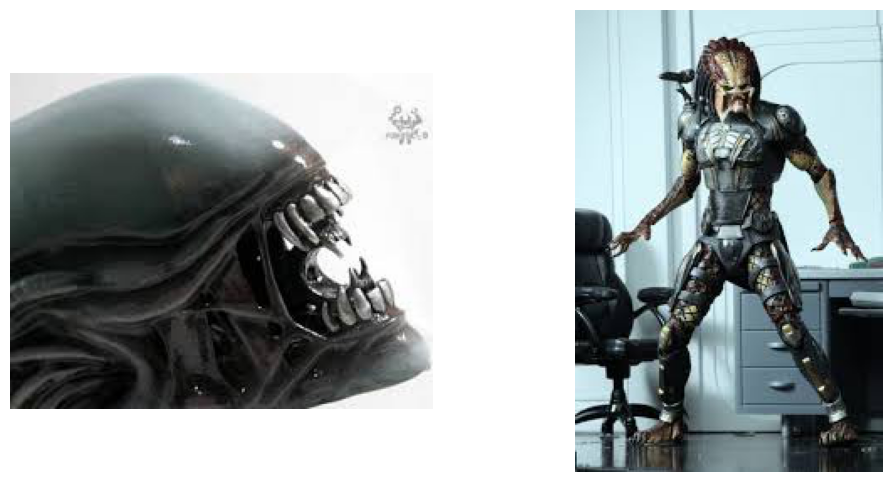

In [ ]:
# 테스트
from PIL import Image  # 이미지를 코랩에서 띄우기


img1 = Image.open('data/validation/alien/32.jpg')   # validation에 있는 이미지 쓰기
img2 = Image.open('data/validation/predator/45.jpg')

fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [ ]:
img1_input = data_transforms['validation'](img1)  # data_transforms의 validation 키의 value 값에 img1을 통과시킴 -> Resize되고 Tensor로 변환
img2_input = data_transforms['validation'](img2)
print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [ ]:
test_batch = torch.stack([img1_input, img2_input])  # 하나의 이미지 텐서로 결합, 두 이미지를 첫 번째 차원(배치 차원)으로 결합
test_batch = test_batch.to(device)
test_batch.shape   # 두 개 이미지가 붙음, torch.Size([2, 3, 224, 224]): (2(배치크기), 컬러채널, 세로, 가로)

torch.Size([2, 3, 224, 224])

In [ ]:
y_pred = model(test_batch)
y_pred

tensor([[0.2478],
        [0.9446]], device='cuda:0', grad_fn=<SigmoidBackward0>)

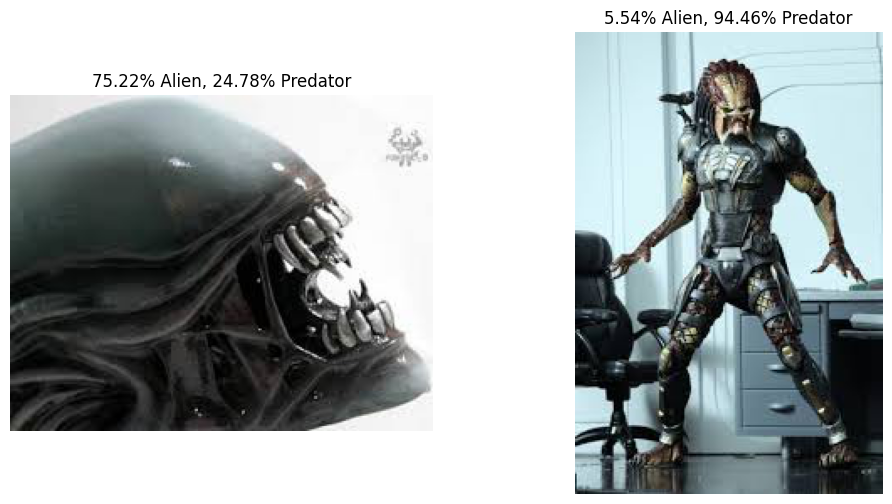

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

axes[0].set_title(f'{(1-y_pred[0,0]) * 100:.2f}% Alien, {y_pred[0,0] * 100:.2f}% Predator')
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].set_title(f'{(1-y_pred[1,0]) * 100:.2f}% Alien, {y_pred[1,0] * 100:.2f}% Predator')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

# 팀 과제
- 전이학습으로 강아지와 고양이 구분하기
- https://www.kaggle.com/c/dogs-vs-cats
- 결과 코랩 깃허브에 올리기

